<a href="https://colab.research.google.com/github/paulinavaso/Tesis/blob/main/GPFlow_Try1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpflow
!pip install tensorflow

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

# Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [7]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [8]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

    return X, Y

In [9]:
X, Y = data = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

 Utility function for plotting:

In [10]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

# Model the outputs of $f(x)$ directly 
The three following examples show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:

$f(x)=Ig(x)$,

i.e. $W=I$ and $P=L$.

## 1. Shared independent multi-output kernel (MOK) and shared independent inducing variables
Here the priors on all outputs are constrained to have the same kernel hyperparameters. We also share the inducing inputs between all outputs. The different GPs are independent both in the prior and the approximate posterior.


In [11]:
# create multi-output kernel
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [12]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
# print_summary(m)

In [13]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

In [ ]:
# print_summary(m)

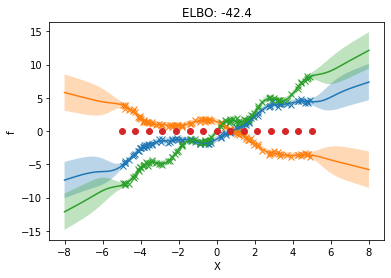

In [14]:
# Plot predictions and observations
plot_model(m)

In [ ]:
# print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

## 2. Separate independent MOK and shared independent inducing variables
Here we allow different hyperparameters for the priors of each output. We still share the inducing inputs between all outputs.

In [15]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
optimize_model_with_scipy(m)

Instructions for updating:
Use fn_output_signature instead


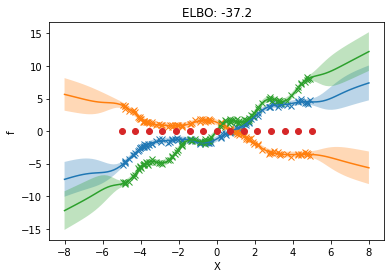

In [16]:
# print_summary(m.kernel)
plot_model(m)

In [17]:
[k.kernels[0].lengthscales for k in m.kernel.kernels]

[<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9347150002351202>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9697226254601755>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7493468182957961>]

## 3. Separate independent kernel and separate independent inducing variables
Here we allow different hyperparameters for the priors of each output. We now allow different inducing inputs for each output.

In [18]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

NOTE: While the inducing points are independent, there needs to be the same number of inducing points per dimension.

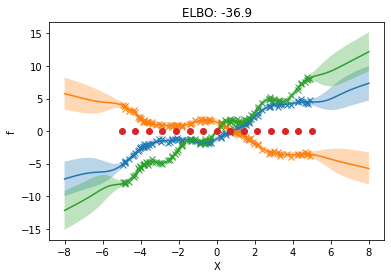

In [19]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
optimize_model_with_scipy(m)
plot_model(m)

The following plot shows that we use different inducing inputs in each output dimension.

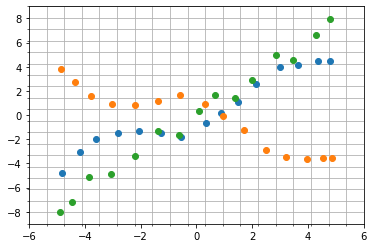

In [20]:
for i in range(len(m.inducing_variable.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variable.inducing_variable_list[i].Z)
    plt.plot(
        m.inducing_variable.inducing_variable_list[i].Z.numpy(),
        q_mu_unwhitened[:, i, None].numpy(),
        "o",
    )
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which="minor")

In [21]:
m.inducing_variable.inducing_variable_list

ListWrapper([<gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7ff68aaac110>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7ff68aaac550>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7ff68aad7650>])